In [1]:
# SET THIS VARIABLE IF 
explained_model_backend = 'sklearn' # 'sklearn' or 'tensorflow'

# WARNING REMEMEBER TO CHANGE MANUALLY CFEC MODEL LOADING IF SOME CHANGES APPEAR 

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import json
from utils.transformations import min_max_normalization, inverse_min_max_normalization, transform_to_sparse, inverse_transform_to_sparse
import warnings
import tensorflow as tf
import pickle

warnings.filterwarnings('ignore', category=UserWarning) #Ignore sklearn "RF fitted with FeatureNames"

train_dataset = pd.read_csv("../data/adult.csv")
dataset_name = 'adult'
instance_to_explain_index = 10

with open('../data/adult_constraints.json', 'r') as f:
    constr = json.load(f)

if explained_model_backend == 'sklearn':
    # SKLEARN
    with open('../models/adult_RF.pkl', 'rb') as f:
        explained_model = pickle.load(f)
else: 
    # TENSORFLOW
    explained_model = tf.keras.models.load_model('../models/adult_NN/')


train_dataset = train_dataset[constr['features_order_nonsplit']]
train_dataset.columns

Index(['hours.per.week', 'age', 'capital.loss', 'education.num',
       'capital.gain', 'workclass', 'marital.status', 'occupation', 'race',
       'sex', 'native.country', 'income'],
      dtype='object')

In [3]:
actionable_mask_indices_sparse = [1 if any([act in x for act in constr['actionable_features']]) else 0 for x in constr['features_order_after_split']]

In [4]:
query_instance = train_dataset.drop(columns="income")[instance_to_explain_index:instance_to_explain_index+1]

all_counterfactuals = pd.DataFrame(columns=train_dataset.columns.tolist() + ['explainer'])

In [5]:
# Transform dataset to sparse
train_dataset_sparse = transform_to_sparse(
    _df=train_dataset.drop(columns="income"),
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

# Min-max normalization
train_dataset_sparse_normalized = min_max_normalization(
    _df=train_dataset_sparse,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)

query_instance_sparse_normalized = train_dataset_sparse_normalized[instance_to_explain_index:instance_to_explain_index+1]

In [6]:
query_instance

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country
10,35,45,3004,16,0,Private,Divorced,Prof-specialty,Black,Female,United-States


DICE

In [7]:
from dice import DiceModel

if explained_model_backend == 'sklearn':
    dice_model = DiceModel(
        train_dataset=train_dataset,
        continuous_features=constr['continuous_features_nonsplit'],
        categorical_features=constr['categorical_features_nonsplit'],
        target=constr['target_feature'],
        model_path='../models/adult_RF.pkl',
        backend='sklearn',
        func='ohe-min-max',
    )
else:
    dice_model = DiceModel(
        train_dataset=train_dataset,
        continuous_features=constr['continuous_features_nonsplit'],
        categorical_features=constr['categorical_features_nonsplit'],
        target=constr['target_feature'],
        model_path='../models/adult_NN/',
        backend='TF2',
        func='ohe-min-max',
    )

dice_counterfactuals_df = dice_model.generate_counterfactuals(
    query_instance=query_instance,
    total_CFs=20,
    desired_class='opposite',
    features_to_vary=constr['actionable_features'],
    permitted_range=constr['feature_ranges'],
)

dice_counterfactuals_df['explainer'] = 'dice'
all_counterfactuals = pd.concat([all_counterfactuals, dice_counterfactuals_df], ignore_index=True)

100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


In [8]:
all_counterfactuals.head(8)

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country,income,explainer
0,7.0,45.0,3004.0,16.0,0.0,Private,Divorced,Prof-specialty,Black,Female,United-States,1,dice
1,2.0,45.0,3004.0,16.0,0.0,Private,Divorced,Prof-specialty,Black,Female,United-States,1,dice
2,35.0,45.0,3004.0,3.0,0.0,Private,Divorced,Other-service,Black,Female,United-States,1,dice
3,1.0,45.0,3004.0,6.0,0.0,Private,Divorced,Prof-specialty,Black,Female,United-States,1,dice
4,1.0,45.0,1950.0,16.0,0.0,Private,Divorced,Prof-specialty,Black,Female,United-States,1,dice
5,3.0,45.0,3004.0,16.0,0.0,Private,Divorced,Prof-specialty,Black,Female,United-States,1,dice
6,35.0,45.0,3004.0,16.0,0.0,Federal-gov,Divorced,?,Black,Female,United-States,1,dice
7,7.0,45.0,3004.0,3.0,0.0,Private,Divorced,Prof-specialty,Black,Female,United-States,1,dice


In [9]:
print(np.where(actionable_mask_indices_sparse)[0].tolist())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]


CFEC

In [10]:
from cfec_ece import CfecEceModel 

train_dataset_sparse_normalized_subsample = train_dataset_sparse_normalized.sample(frac=1.0)

if explained_model_backend == 'sklearn':
    cfec_model = CfecEceModel(
        train_data_normalized=train_dataset_sparse_normalized_subsample,
        constraints_dictionary=constr,
        model_path='../models/adult_RF.pkl',
        model_backend='sklearn',
        fimap_load_s_g_full_id=f'adult_sklearn|2023-01-17',
        #fimap_save_s_q_prefix='adult_sklearn',
        columns_to_change=np.where(actionable_mask_indices_sparse)[0].tolist(),
        )
else:
    cfec_model = CfecEceModel(
        train_data_normalized=train_dataset_sparse_normalized_subsample,
        constraints_dictionary=constr,
        model_path='../models/adult_NN/',
        model_backend='tensorflow',
        fimap_load_s_g_full_id=f'adult_tensorflow|2023-01-17',
        #fimap_save_s_q_prefix='adult_tensorflow',
        columns_to_change=np.where(actionable_mask_indices_sparse)[0].tolist(),
        )

Constraints: 
 [Freeze(columns=['race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Black', 'race_Other', 'race_White']), Freeze(columns=['sex_Female', 'sex_Male']), Freeze(columns=['native.country_?', 'native.country_Cambodia', 'native.country_Canada', 'native.country_China', 'native.country_Columbia', 'native.country_Cuba', 'native.country_Dominican-Republic', 'native.country_Ecuador', 'native.country_El-Salvador', 'native.country_England', 'native.country_France', 'native.country_Germany', 'native.country_Greece', 'native.country_Guatemala', 'native.country_Haiti', 'native.country_Holand-Netherlands', 'native.country_Honduras', 'native.country_Hong', 'native.country_Hungary', 'native.country_India', 'native.country_Iran', 'native.country_Ireland', 'native.country_Italy', 'native.country_Jamaica', 'native.country_Japan', 'native.country_Laos', 'native.country_Mexico', 'native.country_Nicaragua', 'native.country_Outlying-US(Guam-USVI-etc)', 'native.country_Peru', 'native.count

In [11]:
cfec_counterfactuals_raw, list_cfs_explainers = cfec_model.generate_counterfactuals(query_instance=query_instance_sparse_normalized.iloc[0])
cfec_counterfactuals_raw

BCE <modules.CFEC.cfec.explainers._fimap.Fimap object at 0x000001DF79B47550> generated 1 counterfactuals
BCE <modules.CFEC.cfec.explainers._fimap.Fimap object at 0x000001DF747F35B0> generated 1 counterfactuals
BCE <modules.CFEC.cfec.explainers._fimap.Fimap object at 0x000001DF7AE8FFD0> generated 1 counterfactuals
BCE <modules.CFEC.cfec.explainers._fimap.Fimap object at 0x000001DF0003FAF0> generated 1 counterfactuals
BCE <modules.CFEC.cfec.explainers._fimap.Fimap object at 0x000001DF0003FEE0> generated 1 counterfactuals
1/1 [==============================] - 0s 19ms/step
BCE <modules.CFEC.cfec.explainers._cadex.Cadex object at 0x000001DF748635B0> found no countefactuals
1/1 [==============================] - 0s 19ms/step
BCE <modules.CFEC.cfec.explainers._cadex.Cadex object at 0x000001DF74863040> found no countefactuals
1/1 [==============================] - 0s 20ms/step
BCE <modules.CFEC.cfec.explainers._cadex.Cadex object at 0x000001DF74863940> found no countefactuals
1/1 [===========

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
0,-0.585189,-0.189476,0.689624,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00
1,-0.511138,-0.143484,0.689624,1.000000,0.000000,0.665339,0.000000,0.000000,0.000000,1.00000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00
2,-0.413492,-0.094581,0.689624,1.000000,-0.583265,0.575013,0.000000,0.000000,0.000000,1.00000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00
3,-0.326907,-0.074890,0.689624,1.000000,-0.600952,0.590394,0.000000,0.000000,0.000000,0.00000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00
4,-0.280608,-0.092331,0.689624,0.349749,-0.576933,0.499667,0.000000,0.000000,0.000000,0.00000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00
5,-0.186975,-0.037455,1.203073,0.459656,-0.499513,0.457728,0.000000,0.000000,0.000000,0.00000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00
6,-0.163944,0.456713,0.771228,0.728996,0.051822,0.167966,0.198639,0.064279,0.000215,0.69703,...,2.851869e-12,-5.311182e-11,-9.715559e-12,-1.571294e-11,9.338692e-12,-1.077733e-11,6.132937e-12,1.0,-4.705550e-11,-1.123570e-11
7,-0.161343,0.465095,0.765260,0.741070,0.051307,0.170062,0.029483,0.064279,0.000215,0.69703,...,2.851869e-12,-5.311182e-11,-9.715559e-12,-1.571294e-11,9.338692e-12,-1.077733e-11,6.132937e-12,1.0,-4.705550e-11,-1.123570e-11
8,0.019021,0.440938,0.716871,0.859963,0.018177,0.069842,0.029483,0.064279,0.000215,0.69703,...,2.851869e-12,-5.311182e-11,-9.715559e-12,-1.571294e-11,9.338692e-12,-1.077733e-11,6.132937e-12,1.0,-4.705550e-11,-1.123570e-11
9,0.145390,0.432779,0.701516,0.901753,0.010162,0.031357,0.029483,0.064279,0.000215,0.69703,...,2.851869e-12,-5.311182e-11,-9.715559e-12,-1.571294e-11,9.338692e-12,-1.077733e-11,6.132937e-12,1.0,-4.705550e-11,-1.123570e-11


In [12]:
# Do not allow for negative values
cfec_counterfactuals_raw[cfec_counterfactuals_raw < 0] = 0

# Inverse min-max normalization
cfec_counterfactuals = inverse_min_max_normalization(
    _df=cfec_counterfactuals_raw,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)

# Inverse transform to sparse
cfec_counterfactuals = inverse_transform_to_sparse(
    sparse_df=cfec_counterfactuals,
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

d:\Research\ecemosp\src\utils\transformations.py:67: FutureWarning: The default value of regex will change from True to False in a future version.
  dense_df[feature] = sparse_df[split_columns].idxmax(axis=1).str.replace(feature + '_', '')
d:\Research\ecemosp\src\utils\transformations.py:67: FutureWarning: The default value of regex will change from True to False in a future version.
  dense_df[feature] = sparse_df[split_columns].idxmax(axis=1).str.replace(feature + '_', '')


In [13]:
list_cfs_explainers = list(map(lambda x: 'Cadex' if 'Cadex' in x else 'Fimap', list_cfs_explainers))
cfec_counterfactuals['explainer'] = list_cfs_explainers
all_counterfactuals = pd.concat([all_counterfactuals, cfec_counterfactuals], ignore_index=True)
cfec_counterfactuals

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country,explainer
0,1,17,3004,16,0,Private,Married-spouse-absent,Other-service,Black,Male,United-States,Cadex
1,1,17,3004,16,0,Private,Married-spouse-absent,Other-service,Black,Male,United-States,Cadex
2,1,17,3004,16,0,Private,Married-spouse-absent,Other-service,Black,Male,United-States,Cadex
3,1,17,3004,16,0,?,Divorced,Other-service,Black,Male,United-States,Cadex
4,1,17,3004,6,0,?,Divorced,Other-service,Black,Male,United-States,Cadex
5,1,17,5240,7,0,?,Divorced,Other-service,Black,Male,United-States,Cadex
6,1,50,3359,11,5182,Private,Married-civ-spouse,Prof-specialty,Black,Female,United-States,Fimap
7,1,50,3333,12,5130,Private,Married-civ-spouse,Prof-specialty,Black,Female,United-States,Fimap
8,2,49,3122,13,1817,Private,Married-civ-spouse,Prof-specialty,Black,Female,United-States,Fimap
9,15,48,3055,14,1016,Private,Divorced,Prof-specialty,Black,Female,United-States,Fimap


In [14]:
query_instance_sparse_normalized[cfec_counterfactuals_raw.columns[39:]]

,race_Other,race_White,sex_Female,sex_Male,native.country_?,native.country_Cambodia,native.country_Canada,native.country_China,native.country_Columbia,native.country_Cuba,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
10,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [15]:
cfec_counterfactuals_raw[cfec_counterfactuals_raw.columns[39:]]

,race_Other,race_White,sex_Female,sex_Male,native.country_?,native.country_Cambodia,native.country_Canada,native.country_China,native.country_Columbia,native.country_Cuba,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
0,0.000000e+00,0.000000e+00,0.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0
1,0.000000e+00,0.000000e+00,0.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0
2,0.000000e+00,0.000000e+00,0.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0
3,0.000000e+00,0.000000e+00,0.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0
4,0.000000e+00,0.000000e+00,0.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0
5,0.000000e+00,0.000000e+00,0.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0
6,1.298469e-10,2.480092e-08,1.0,1.042757e-08,7.982684e-10,6.132937e-12,4.038956e-11,0.0,4.754096e-11,3.583714e-11,...,2.851869e-12,0.0,0.0,0.0,9.338692e-12,0.0,6.132937e-12,1.0,0.0,0.0
7,1.298469e-10,2.480092e-08,1.0,1.042757e-08,7.982684e-10,6.132937e-12,4.038956e-11,0.0,4.754096e-11,3.583714e-11,...,2.851869e-12,0.0,0.0,0.0,9.338692e-12,0.0,6.132937e-12,1.0,0.0,0.0
8,1.298469e-10,2.480092e-08,1.0,1.042757e-08,7.982684e-10,6.132937e-12,4.038956e-11,0.0,4.754096e-11,3.583714e-11,...,2.851869e-12,0.0,0.0,0.0,9.338692e-12,0.0,6.132937e-12,1.0,0.0,0.0
9,1.298469e-10,2.480092e-08,1.0,1.042757e-08,7.982684e-10,6.132937e-12,4.038956e-11,0.0,4.754096e-11,3.583714e-11,...,2.851869e-12,0.0,0.0,0.0,9.338692e-12,0.0,6.132937e-12,1.0,0.0,0.0


WACHTER

In [16]:
from alibi_impl import AlibiWachter

continous = len(constr['continuous_features_nonsplit'])
eps_wachter = np.array([[0.1] * continous + [1.0] * (len(train_dataset_sparse_normalized.columns) - continous)])# * (np.array(actionable_mask_indices_sparse, dtype=int) + 0.001)
#eps_wachter = 0.01

# Dont allow perturbations on non-actionable features
#eps_wachter = actionable_mask_indices_sparse * eps_wachter

if explained_model_backend == 'sklearn':
    wachter_model = AlibiWachter('../models/adult_RF.pkl', 'sklearn', query_instance_sparse_normalized.shape, eps=eps_wachter)
else:
    wachter_model = AlibiWachter('../models/adult_NN/', 'tensorflow', query_instance_sparse_normalized.shape, eps=eps_wachter)
    
explanation = wachter_model.generate_counterfactuals(query_instance_sparse_normalized)

c:\ProgramData\Anaconda3\envs\cf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
wachter_counterfactuals = [explanation.cf['X']]
for key, lst in explanation['data']['all'].items():
    if lst:
        for cf in lst:
            wachter_counterfactuals.append(cf['X'])

wachter_counterfactuals = np.array(wachter_counterfactuals).reshape(-1, query_instance_sparse_normalized.shape[1])

wachter_counterfactuals_df = pd.DataFrame(wachter_counterfactuals, columns=constr['features_order_after_split'])

# Inverse min-max normalization
wachter_counterfactuals_df = inverse_min_max_normalization(
    _df=wachter_counterfactuals_df,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)

# Inverse transform to sparse
wachter_counterfactuals_df = inverse_transform_to_sparse(
    sparse_df=wachter_counterfactuals_df,
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

wachter_counterfactuals_df['explainer'] = 'wachter'

# Reduce number of Wachter counterfactuals because they are almost the same
sampled_wachter_cfs = wachter_counterfactuals_df.sample(min(len(wachter_counterfactuals_df), 10))

sampled_wachter_cfs.append(wachter_counterfactuals_df.iloc[0])

all_counterfactuals = pd.concat([all_counterfactuals, sampled_wachter_cfs], ignore_index=True)

wachter_counterfactuals_df.head(5)

C:\Users\ignacy\AppData\Local\Temp\ipykernel_19372\167751939.py:2: DeprecationWarning: The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
  for key, lst in explanation['data']['all'].items():
d:\Research\ecemosp\src\utils\transformations.py:67: FutureWarning: The default value of regex will change from True to False in a future version.
  dense_df[feature] = sparse_df[split_columns].idxmax(axis=1).str.replace(feature + '_', '')
d:\Research\ecemosp\src\utils\transformations.py:67: FutureWarning: The default value of regex will change from True to False in a future version.
  dense_df[feature] = sparse_df[split_columns].idxmax(axis=1).str.replace(feature + '_', '')
C:\Users\ignacy\AppData\Local\Temp\ipykernel_19372\167751939.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sampled

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country,explainer
0,98,90,4341,1,0,Private,Divorced,Adm-clerical,Black,Female,Mexico,wachter
1,99,17,0,1,99999,Federal-gov,Married-AF-spouse,?,Amer-Indian-Eskimo,Female,Cambodia,wachter
2,99,17,0,1,99999,Federal-gov,Married-AF-spouse,?,Amer-Indian-Eskimo,Female,Cambodia,wachter
3,99,17,0,1,99999,Federal-gov,Married-AF-spouse,?,Amer-Indian-Eskimo,Female,Cambodia,wachter
4,99,17,0,1,99999,Federal-gov,Married-AF-spouse,?,Amer-Indian-Eskimo,Female,Cambodia,wachter


In [18]:
wachter_counterfactuals_df.shape

(21, 12)

CEM

In [19]:
from alibi.explainers import CEM

tf.keras.backend.clear_session()
tf.compat.v1.disable_eager_execution()

if explained_model_backend == 'sklearn':
    # SKLEARN
    with open('../models/adult_RF.pkl', 'rb') as f:
        explained_model = pickle.load(f)
else: 
    # TENSORFLOW
    explained_model = tf.keras.models.load_model('../models/adult_NN/')

shape = query_instance_sparse_normalized.shape  # instance shape
continous = len(constr['continuous_features_nonsplit'])
clip = (-1000.,1000.)
eps_cem = (
        0.05,
        np.array([[0.05] * continous + [1.0] * (len(train_dataset_sparse_normalized.columns) - continous)]) * (np.array(actionable_mask_indices_sparse) + 0.001) # Dont allow changes on non-actionable features
        )


if explained_model_backend == 'sklearn':
    mode = 'PN'
    feature_range = (train_dataset_sparse_normalized.to_numpy().min(),  # feature range for the perturbed instance
                    train_dataset_sparse_normalized.to_numpy().max()) 
    update_num_grad = 4
    c_init = 10.  # initial weight c of the loss term encouraging to predict a different class (PN) or
                # the same class (PP) for the perturbed instance compared to the original instance to be explained
    # Return probabilities for x
    cem_pred_fn = lambda x: np.array(explained_model.predict_proba(x)[0])#explained_model.predict_proba(x)[0][0][::-1].reshape(1, 2)#np.array([explained_model.predict_proba(x)[0][0][1], explained_model.predict_proba(x)[0][0][0]])

    cem = CEM(cem_pred_fn, mode, shape, kappa=0.0, beta=0.2, feature_range=feature_range, 
            eps=eps_cem, update_num_grad=update_num_grad, clip=clip, no_info_val=-0.0, c_init=c_init,
            c_steps=10, learning_rate_init=.9, max_iterations=50
            )
else:
    mode = 'PN'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
    kappa = .0  # minimum difference needed between the prediction probability for the perturbed instance on the
                # class predicted by the original instance and the max probability on the other classes
                # in order for the first loss term to be minimized
    beta = .1  # weight of the L1 loss term
    c_init = 10  # initial weight c of the loss term encouraging to predict a different class (PN) or
                # the same class (PP) for the perturbed instance compared to the original instance to be explained
   
    c_steps = 10  # nb of updates for c
    max_iterations = 1000  # nb of iterations per value of c
    # feature_range = (train_dataset_sparse_normalized.to_numpy().min(axis=0).reshape(shape),  # feature range for the perturbed instance
    #                 train_dataset_sparse_normalized.to_numpy().max(axis=0).reshape(shape))  # can be either a float or array of shape (1xfeatures)
    feature_range = (train_dataset_sparse_normalized.to_numpy().min(),train_dataset_sparse_normalized.to_numpy().max())  # can be either a float or array of shape (1xfeatures)
      # gradient clipping
    lr_init = 1e-2  # initial learning rate

    # initialize CEM explainer and explain instance
    cem = CEM(explained_model, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
            max_iterations=max_iterations, c_init=c_init, c_steps=c_steps,
            learning_rate_init=lr_init, clip=clip, no_info_val=0.0)

cem.fit(train_dataset_sparse_normalized.to_numpy(), no_info_type='median')  # we need to define what feature values contain the least
                                                                    # info wrt predictions
                                                                    # here we will naively assume that the feature-wise median
                                                                    # contains no info; domain knowledge helps!

"no_info_type" variable already defined. Previous values will be overwritten.


CEM(meta={
  'name': 'CEM',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'mode': 'PN',
              'shape': (1, 85),
              'kappa': 0.0,
              'beta': 0.2,
              'feature_range': (0.0, 1.0),
              'gamma': 0.0,
              'learning_rate_init': 0.9,
              'max_iterations': 50,
              'c_init': 10.0,
              'c_steps': 10,
              'eps': (0.05, array([[5.005e-02, 5.005e-02, 5.005e-02, 5.005e-02, 5.005e-02, 1.001e+00,
        1.001e+00, 1.001e+00, 1.001e+00, 1.001e+00, 1.001e+00, 1.001e+00,
        1.001e+00, 1.001e+00, 1.001e+00, 1.001e+00, 1.001e+00, 1.001e+00,
        1.001e+00, 1.001e+00, 1.001e+00, 1.001e+00, 1.001e+00, 1.001e+00,
        1.001e+00, 1.001e+00, 1.001e+00, 1.001e+00, 1.001e+00, 1.001e+00,
        1.001e+00, 1.001e+00, 1.001e+00, 1.001e+00, 1.001e+00, 1.001e+00,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        1.000e

In [20]:
cem_explanation = cem.explain(query_instance_sparse_normalized, verbose=True)

cem_cf_df = pd.DataFrame(cem_explanation.PN, columns=constr['features_order_after_split'])

# Inverse min-max normalization
cem_cf_df = inverse_min_max_normalization(
    _df=cem_cf_df,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)

# Inverse transform to sparse
cem_cf_df = inverse_transform_to_sparse(
    sparse_df=cem_cf_df,
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

cem_cf_df['explainer'] = 'Cem'

all_counterfactuals = pd.concat([all_counterfactuals, cem_cf_df], ignore_index=True)

cem_cf_df


Iteration: 0; Const: 10.0
Loss total: 1.868, loss attack: 1.868
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 0.59, max non target proba: 0.41
Gradient graph min/max: -0.000/-0.000
Gradient graph mean/abs mean: 0.000/0.000
Gradient numerical attack min/max: 0.000/0.000
Gradient numerical mean/abs mean: 0.000/0.000

New best PN found!

Iteration: 5; Const: 10.0
Loss total: 1.868, loss attack: 1.868
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 0.59, max non target proba: 0.41
Gradient graph min/max: -0.320/2.702
Gradient graph mean/abs mean: 0.214/0.222
Gradient numerical attack min/max: 0.000/0.000
Gradient numerical mean/abs mean: 0.000/0.000

Iteration: 10; Const: 10.0
Loss total: 1.868, loss attack: 1.868
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 0.59, max non target proba: 0.41
Gradient graph min/max: -0.000/-0.000
Gradient graph mean/abs mean: 0.000/0.000
Gradient numerical attack min/max: 0.000/0.000
Gradient numerical mean/abs mean: 0.000/0.000

Iteration: 15

d:\Research\ecemosp\src\utils\transformations.py:67: FutureWarning: The default value of regex will change from True to False in a future version.
  dense_df[feature] = sparse_df[split_columns].idxmax(axis=1).str.replace(feature + '_', '')
d:\Research\ecemosp\src\utils\transformations.py:67: FutureWarning: The default value of regex will change from True to False in a future version.
  dense_df[feature] = sparse_df[split_columns].idxmax(axis=1).str.replace(feature + '_', '')


,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country,explainer
0,68,90,1670,1,34693,Private,Divorced,Prof-specialty,Black,Female,United-States,Cem


CFPROTO

In [21]:
# from alibi.explainers import CounterfactualProto

# import pickle
# with open('../models/adult_RF.pkl', 'rb') as f:
#     cfprot_model = pickle.load(f)
# predict_fnct = lambda x: cfprot_model.predict(x)


In [22]:
# cat_vars_ord = {}
# for i, cat in enumerate(constr['categorical_features_nonsplit']):
#     start_index = np.argwhere(cat == train_dataset.columns.to_numpy())[0][0]
#     unique = len(np.unique(train_dataset[cat]))
#     cat_vars_ord[start_index] = unique
# print(cat_vars_ord)

In [23]:
# cat_vars_ohe = {}
# for f in constr['categorical_features_nonsplit']:
#     indx = constr['feature_first_occurrence_after_split'][f]
#     cnt = constr['features_count_nonsplit'][f] 
#     cat_vars_ohe[indx] = cnt
# cat_vars_ohe

In [24]:
# cfProto = CounterfactualProto(predict_fnct,
#                          query_instance_sparse_normalized.shape,
#                          cat_vars=cat_vars_ohe,
#                          ohe=True,  # OHE flag
#                          max_iterations=500,
#                          beta=0.01,
#                          feature_range=(0.0, 1.0),
#                         #  use_kdtree=True,
#                          theta= 10.,
#                          c_init=1.0,
#                          c_steps=5,
#                         )

In [25]:

# cfProto.fit(train_dataset_sparse_normalized.to_numpy().astype('float64'), d_type='abdm', trustscore_kwargs=None)

In [26]:
# explanation = cfProto.explain(query_instance_sparse_normalized.to_numpy())

In [27]:
# all_counterfactuals

VISUALIZATION

In [28]:
from visualization_helpers import get_scores
from visualization_helpers import remove_duplicates

all_counterfactuals = remove_duplicates(all_counterfactuals)
print('Counterfactuals: ', all_counterfactuals.shape)

# Transform counterfactuals to sparse
counterfactuals_sparse = transform_to_sparse(
    _df=all_counterfactuals,
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

# Normalize counterfactuals
counterfactuals_sparse_normalized = min_max_normalization(
    _df=counterfactuals_sparse,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)


# Transform query instance to sparse
query_instance_sparse = transform_to_sparse(
    _df=query_instance,
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

# Normalize query instance sparse
query_instance_sparse_normalized = min_max_normalization(
    _df=query_instance_sparse,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)

# Mask non actionable features
mask_indices = [1 if any([act in x for act in constr['actionable_features']]) else 0 for x in constr['features_order_after_split']]

Counterfactuals:  (39, 13)


In [29]:
if explained_model_backend == 'sklearn':

    cems = all_counterfactuals[all_counterfactuals['explainer'] == 'Cem'].index.tolist()
    wachters = all_counterfactuals[all_counterfactuals['explainer'] == 'wachter'].index.tolist()
    cadexes = all_counterfactuals[all_counterfactuals['explainer'] == 'Cadex'].index.tolist()
    fimaps = all_counterfactuals[all_counterfactuals['explainer'] == 'Fimap'].index.tolist()


    print('Orginal x: ',explained_model.predict_proba(query_instance_sparse_normalized)[0] )

    if len(cems) > 0:
        print('cem: ', explained_model.predict_proba(counterfactuals_sparse_normalized.iloc[cems].to_numpy().reshape(-1, 85))[0])
    if len(wachters) > 0:
        print('wachters: ', explained_model.predict_proba(counterfactuals_sparse_normalized.iloc[wachters].to_numpy().reshape(-1, 85))[0])
    if len(cadexes) > 0:
        print('cadexes: ', explained_model.predict_proba(counterfactuals_sparse_normalized.iloc[cadexes].to_numpy().reshape(-1, 85))[0])
    if len(fimaps) > 0:
        print('fimaps: ', explained_model.predict_proba(counterfactuals_sparse_normalized.iloc[fimaps].to_numpy().reshape(-1, 85))[0])

Orginal x:  [[0.59342025 0.40657975]]
cem:  [[0.74743535 0.25256465]]
wachters:  [[0.61072602 0.38927398]
 [0.03102046 0.96897954]
 [0.0427629  0.9572371 ]
 [0.54106735 0.45893265]
 [0.17706961 0.82293039]
 [0.58470981 0.41529019]
 [0.6337404  0.3662596 ]
 [0.04895543 0.95104457]
 [0.46056325 0.53943675]]
cadexes:  [[0.24025461 0.75974539]
 [0.23166128 0.76833872]
 [0.21457553 0.78542447]
 [0.2236824  0.7763176 ]]
fimaps:  [[0.36141916 0.63858084]
 [0.33226986 0.66773014]
 [0.33115875 0.66884125]
 [0.58817783 0.41182217]
 [0.5707025  0.4292975 ]]


In [30]:
from visualization_helpers import filter_non_valid
from visualization_helpers import filter_non_actionable_features

# # SKLEARN
# with open('../models/adult_RF.pkl', 'rb') as f:
#     model = pickle.load(f)

# # TENSORFLOW
# model = tf.keras.models.load_model('../models/adult_NN/')

if explained_model_backend == 'sklearn':
    # SKLEARN
    with open('../models/adult_RF.pkl', 'rb') as f:
        explained_model = pickle.load(f)
else: 
    # TENSORFLOW
    explained_model = tf.keras.models.load_model('../models/adult_NN/')

predict_fn = lambda x: explained_model.predict(x)

valid_counterfactuals_sparse_normalized = filter_non_valid(predict_fn, query_instance_sparse_normalized, counterfactuals_sparse_normalized)
valid_counterfactuals_sparse_normalized.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 30, 31, 33, 36, 37],
           dtype='int64')

In [31]:
#Filter not feasible (data is min-max normalized, so values shouldn't be less than zero)
# not_feasible = np.where(np.sum(counterfactuals_sparse_normalized < 0, axis=1) > 0)[0]
not_feasible = []

indices_to_keep = list(filter(lambda x: x not in not_feasible, valid_counterfactuals_sparse_normalized.index.tolist()))
valid_counterfactuals_sparse_normalized = counterfactuals_sparse_normalized.iloc[indices_to_keep]
print(indices_to_keep)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 30, 31, 33, 36, 37]


In [32]:
valid_counterfactuals_sparse_normalized.head(5)

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
0,0.061224,0.383562,0.689624,1.000000,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0.010204,0.383562,0.689624,1.000000,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0.346939,0.383562,0.689624,0.133333,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0.000000,0.383562,0.689624,0.333333,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0.000000,0.383562,0.447658,1.000000,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [33]:
all_counterfactuals.iloc[indices_to_keep]

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country,income,explainer
0,7.0,45.0,3004.0,16.0,0.0,Private,Divorced,Prof-specialty,Black,Female,United-States,1,dice
1,2.0,45.0,3004.0,16.0,0.0,Private,Divorced,Prof-specialty,Black,Female,United-States,1,dice
2,35.0,45.0,3004.0,3.0,0.0,Private,Divorced,Other-service,Black,Female,United-States,1,dice
3,1.0,45.0,3004.0,6.0,0.0,Private,Divorced,Prof-specialty,Black,Female,United-States,1,dice
4,1.0,45.0,1950.0,16.0,0.0,Private,Divorced,Prof-specialty,Black,Female,United-States,1,dice
5,3.0,45.0,3004.0,16.0,0.0,Private,Divorced,Prof-specialty,Black,Female,United-States,1,dice
6,35.0,45.0,3004.0,16.0,0.0,Federal-gov,Divorced,?,Black,Female,United-States,1,dice
7,7.0,45.0,3004.0,3.0,0.0,Private,Divorced,Prof-specialty,Black,Female,United-States,1,dice
8,2.0,45.0,3004.0,6.0,0.0,Private,Divorced,Prof-specialty,Black,Female,United-States,1,dice
9,5.0,45.0,3004.0,4.0,0.0,Private,Divorced,Prof-specialty,Black,Female,United-States,1,dice


In [34]:
valid_counterfactuals = all_counterfactuals.iloc[indices_to_keep]
valid_counterfactuals.reset_index(drop=True, inplace=True)
valid_counterfactuals = filter_non_actionable_features(valid_counterfactuals, query_instance, constr['non_actionable_features'], constr['categorical_features_nonsplit'], constr['continuous_features_nonsplit'])
valid_counterfactuals_sparse_normalized = valid_counterfactuals_sparse_normalized.iloc[valid_counterfactuals.index.tolist()]
valid_counterfactuals_sparse_normalized.reset_index(drop=True, inplace=True)
valid_counterfactuals.reset_index(drop=True, inplace=True)
valid_counterfactuals.shape

nonactionablecat ['race', 'sex', 'native.country']
nonactionablecat []


(23, 13)

In [35]:
# add income column
valid_counterfactuals['income'] = np.argmax(predict_fn(valid_counterfactuals_sparse_normalized.to_numpy()[0:1]))
valid_counterfactuals

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country,income,explainer
0,7.0,45.0,3004.0,16.0,0.0,Private,Divorced,Prof-specialty,Black,Female,United-States,0,dice
1,2.0,45.0,3004.0,16.0,0.0,Private,Divorced,Prof-specialty,Black,Female,United-States,0,dice
2,35.0,45.0,3004.0,3.0,0.0,Private,Divorced,Other-service,Black,Female,United-States,0,dice
3,1.0,45.0,3004.0,6.0,0.0,Private,Divorced,Prof-specialty,Black,Female,United-States,0,dice
4,1.0,45.0,1950.0,16.0,0.0,Private,Divorced,Prof-specialty,Black,Female,United-States,0,dice
5,3.0,45.0,3004.0,16.0,0.0,Private,Divorced,Prof-specialty,Black,Female,United-States,0,dice
6,35.0,45.0,3004.0,16.0,0.0,Federal-gov,Divorced,?,Black,Female,United-States,0,dice
7,7.0,45.0,3004.0,3.0,0.0,Private,Divorced,Prof-specialty,Black,Female,United-States,0,dice
8,2.0,45.0,3004.0,6.0,0.0,Private,Divorced,Prof-specialty,Black,Female,United-States,0,dice
9,5.0,45.0,3004.0,4.0,0.0,Private,Divorced,Prof-specialty,Black,Female,United-States,0,dice


In [36]:
#scores_df = get_scores(valid_counterfactuals_sparse_normalized.to_numpy(), query_instance_sparse_normalized, train_dataset_sparse_normalized, train_dataset['income'], mask_indices)

In [37]:
train_data_predicted_classes = np.argmax(predict_fn(train_dataset_sparse_normalized), axis=1)
x_predicted_class = np.argmax(predict_fn(query_instance_sparse_normalized))

In [38]:
cols = train_dataset.drop(['income'], axis=1).columns.tolist()
continous_indices = list()
categorical_indices = list()

for col in constr['continuous_features_nonsplit']:
    continous_indices += [cols.index(col)]

for col in constr['categorical_features_nonsplit']:
    categorical_indices += [cols.index(col)]

print(continous_indices)
print(categorical_indices)
print('Proper indices extracted: ', len(categorical_indices + continous_indices) == len(cols))

[0, 1, 2, 3, 4]
[5, 6, 7, 8, 9, 10]
Proper indices extracted:  True


In [39]:
preferences = [0, 4, 2, 3, 5, 1]

print(f'Preferences: {np.array(cols)[preferences]}')

Preferences: ['hours.per.week' 'capital.gain' 'capital.loss' 'education.num'
 'workclass' 'age']


In [40]:
from utils.scores import get_scores


scores_df = get_scores(
    cfs=valid_counterfactuals.drop(['income', 'explainer'], axis=1).to_numpy().astype('<U11'),
    cf_predicted_classes=valid_counterfactuals['income'].to_numpy(),
    x=query_instance.to_numpy()[0].astype('<U11'),
    x_predicted_class=x_predicted_class,
    training_data=train_dataset.drop(['income'], axis=1).to_numpy().astype('<U11'),
    training_data_predicted_classes=train_data_predicted_classes,
    continous_indices=continous_indices,
    categorical_indices=categorical_indices,
    preferences_ranking=preferences,
)

Feasibility: 1.1584
Feasibility w.r.t k-neigbors k=50: 1.9358
Features changed (normalized): 0.0909
Proximity: 0.2857
Discriminative power k=20: 0.0000
DCG @ 6: 0.2857
Feasibility: 1.2094
Feasibility w.r.t k-neigbors k=50: 1.9866
Features changed (normalized): 0.0909
Proximity: 0.3367
Discriminative power k=20: 0.0000
DCG @ 6: 0.3367
Feasibility: 0.7125
Feasibility w.r.t k-neigbors k=50: 1.2564
Features changed (normalized): 0.1818
Proximity: 1.8667
Discriminative power k=20: 0.1000
DCG @ 6: 0.3733
Feasibility: 1.3561
Feasibility w.r.t k-neigbors k=50: 1.9926
Features changed (normalized): 0.1818
Proximity: 1.0136
Discriminative power k=20: 0.1000
DCG @ 6: 0.6341
Feasibility: 0.9777
Feasibility w.r.t k-neigbors k=50: 1.7659
Features changed (normalized): 0.1818
Proximity: 0.5889
Discriminative power k=20: 0.0000
DCG @ 6: 0.4679
Feasibility: 1.1992
Feasibility w.r.t k-neigbors k=50: 1.9764
Features changed (normalized): 0.0909
Proximity: 0.3265
Discriminative power k=20: 0.0000
DCG @ 6:

In [41]:
scores_df['explainer'] = valid_counterfactuals['explainer']
scores_df.head(10)

,Proximity,Feasibility,Feasibility w.r.t k-neigbors k=50,Features Changed (normalized),Discriminative Power k=20,DCG @6,explainer
0,0.285714,1.158424,1.935804,0.090909,0.00,0.285714,dice
1,0.336735,1.209445,1.986625,0.090909,0.00,0.336735,dice
2,1.866667,0.712521,1.256434,0.181818,0.10,0.373253,dice
3,1.013605,1.356076,1.992593,0.181818,0.10,0.634056,dice
4,0.588904,0.977684,1.765939,0.181818,0.00,0.467921,dice
5,0.326531,1.199241,1.976421,0.090909,0.00,0.326531,dice
6,2.000000,1.621331,2.271982,0.181818,0.35,0.386853,dice
7,1.152381,1.392568,2.105495,0.181818,0.05,0.658967,dice
8,1.003401,1.345872,1.982389,0.181818,0.10,0.623852,dice
9,1.106122,1.346310,2.063754,0.181818,0.10,0.650664,dice


In [42]:
import seaborn as sns

# We want to plot only subset of columns 
#scores_to_plot = scores_df.drop(['cf', 'actionability', 'preference_dcg', 'discriminative_power'], axis=1)
scores_to_plot = scores_df.copy()

max_columns = ['Discriminative Power k=20', 'DCG @6']

#scores_to_plot[max_columns] = -1 * scores_to_plot[max_columns]

# # Pairplot
# sns.pairplot(scores_to_plot, hue="explainer", diag_kind='kde')

In [43]:
scores_to_plot.head(5)

,Proximity,Feasibility,Feasibility w.r.t k-neigbors k=50,Features Changed (normalized),Discriminative Power k=20,DCG @6,explainer
0,0.285714,1.158424,1.935804,0.090909,0.0,0.285714,dice
1,0.336735,1.209445,1.986625,0.090909,0.0,0.336735,dice
2,1.866667,0.712521,1.256434,0.181818,0.1,0.373253,dice
3,1.013605,1.356076,1.992593,0.181818,0.1,0.634056,dice
4,0.588904,0.977684,1.765939,0.181818,0.0,0.467921,dice


In [44]:
if 'sklearn' in str(type(explained_model)):
    explained_model_name = 'RF'
else:
    explained_model_name = 'NN'

In [45]:
def get_optimization_direction(metric_name: str) -> str:
    cost_criteria = ['feasibility', 'proximity', 'features']
    gain_criteria = ['discriminative', 'dcg']

    cost = any([True if x.lower() in metric_name.lower() else False for x in cost_criteria])
    if cost:
        return 'min'
    else:
        return 'max'
        
get_optimization_direction('Feasibility')

'min'

For explainer: Fimap and metrics Feasibility, Proximity, paretos: 0 out of 3
For explainer: dice and metrics Feasibility, Proximity, paretos: 3 out of 20
For explainer: Fimap and metrics Feasibility w.r.t k-neigbors k=50, Proximity, paretos: 0 out of 3
For explainer: dice and metrics Feasibility w.r.t k-neigbors k=50, Proximity, paretos: 4 out of 20
For explainer: Fimap and metrics Features Changed (normalized), Proximity, paretos: 0 out of 3
For explainer: dice and metrics Features Changed (normalized), Proximity, paretos: 1 out of 20
For explainer: Fimap and metrics Discriminative Power k=20, Proximity, paretos: 0 out of 3
For explainer: dice and metrics Discriminative Power k=20, Proximity, paretos: 3 out of 20
For explainer: Fimap and metrics DCG @6, Proximity, paretos: 0 out of 3
For explainer: dice and metrics DCG @6, Proximity, paretos: 10 out of 20
For explainer: Fimap and metrics Feasibility w.r.t k-neigbors k=50, Feasibility, paretos: 0 out of 3
For explainer: dice and metric

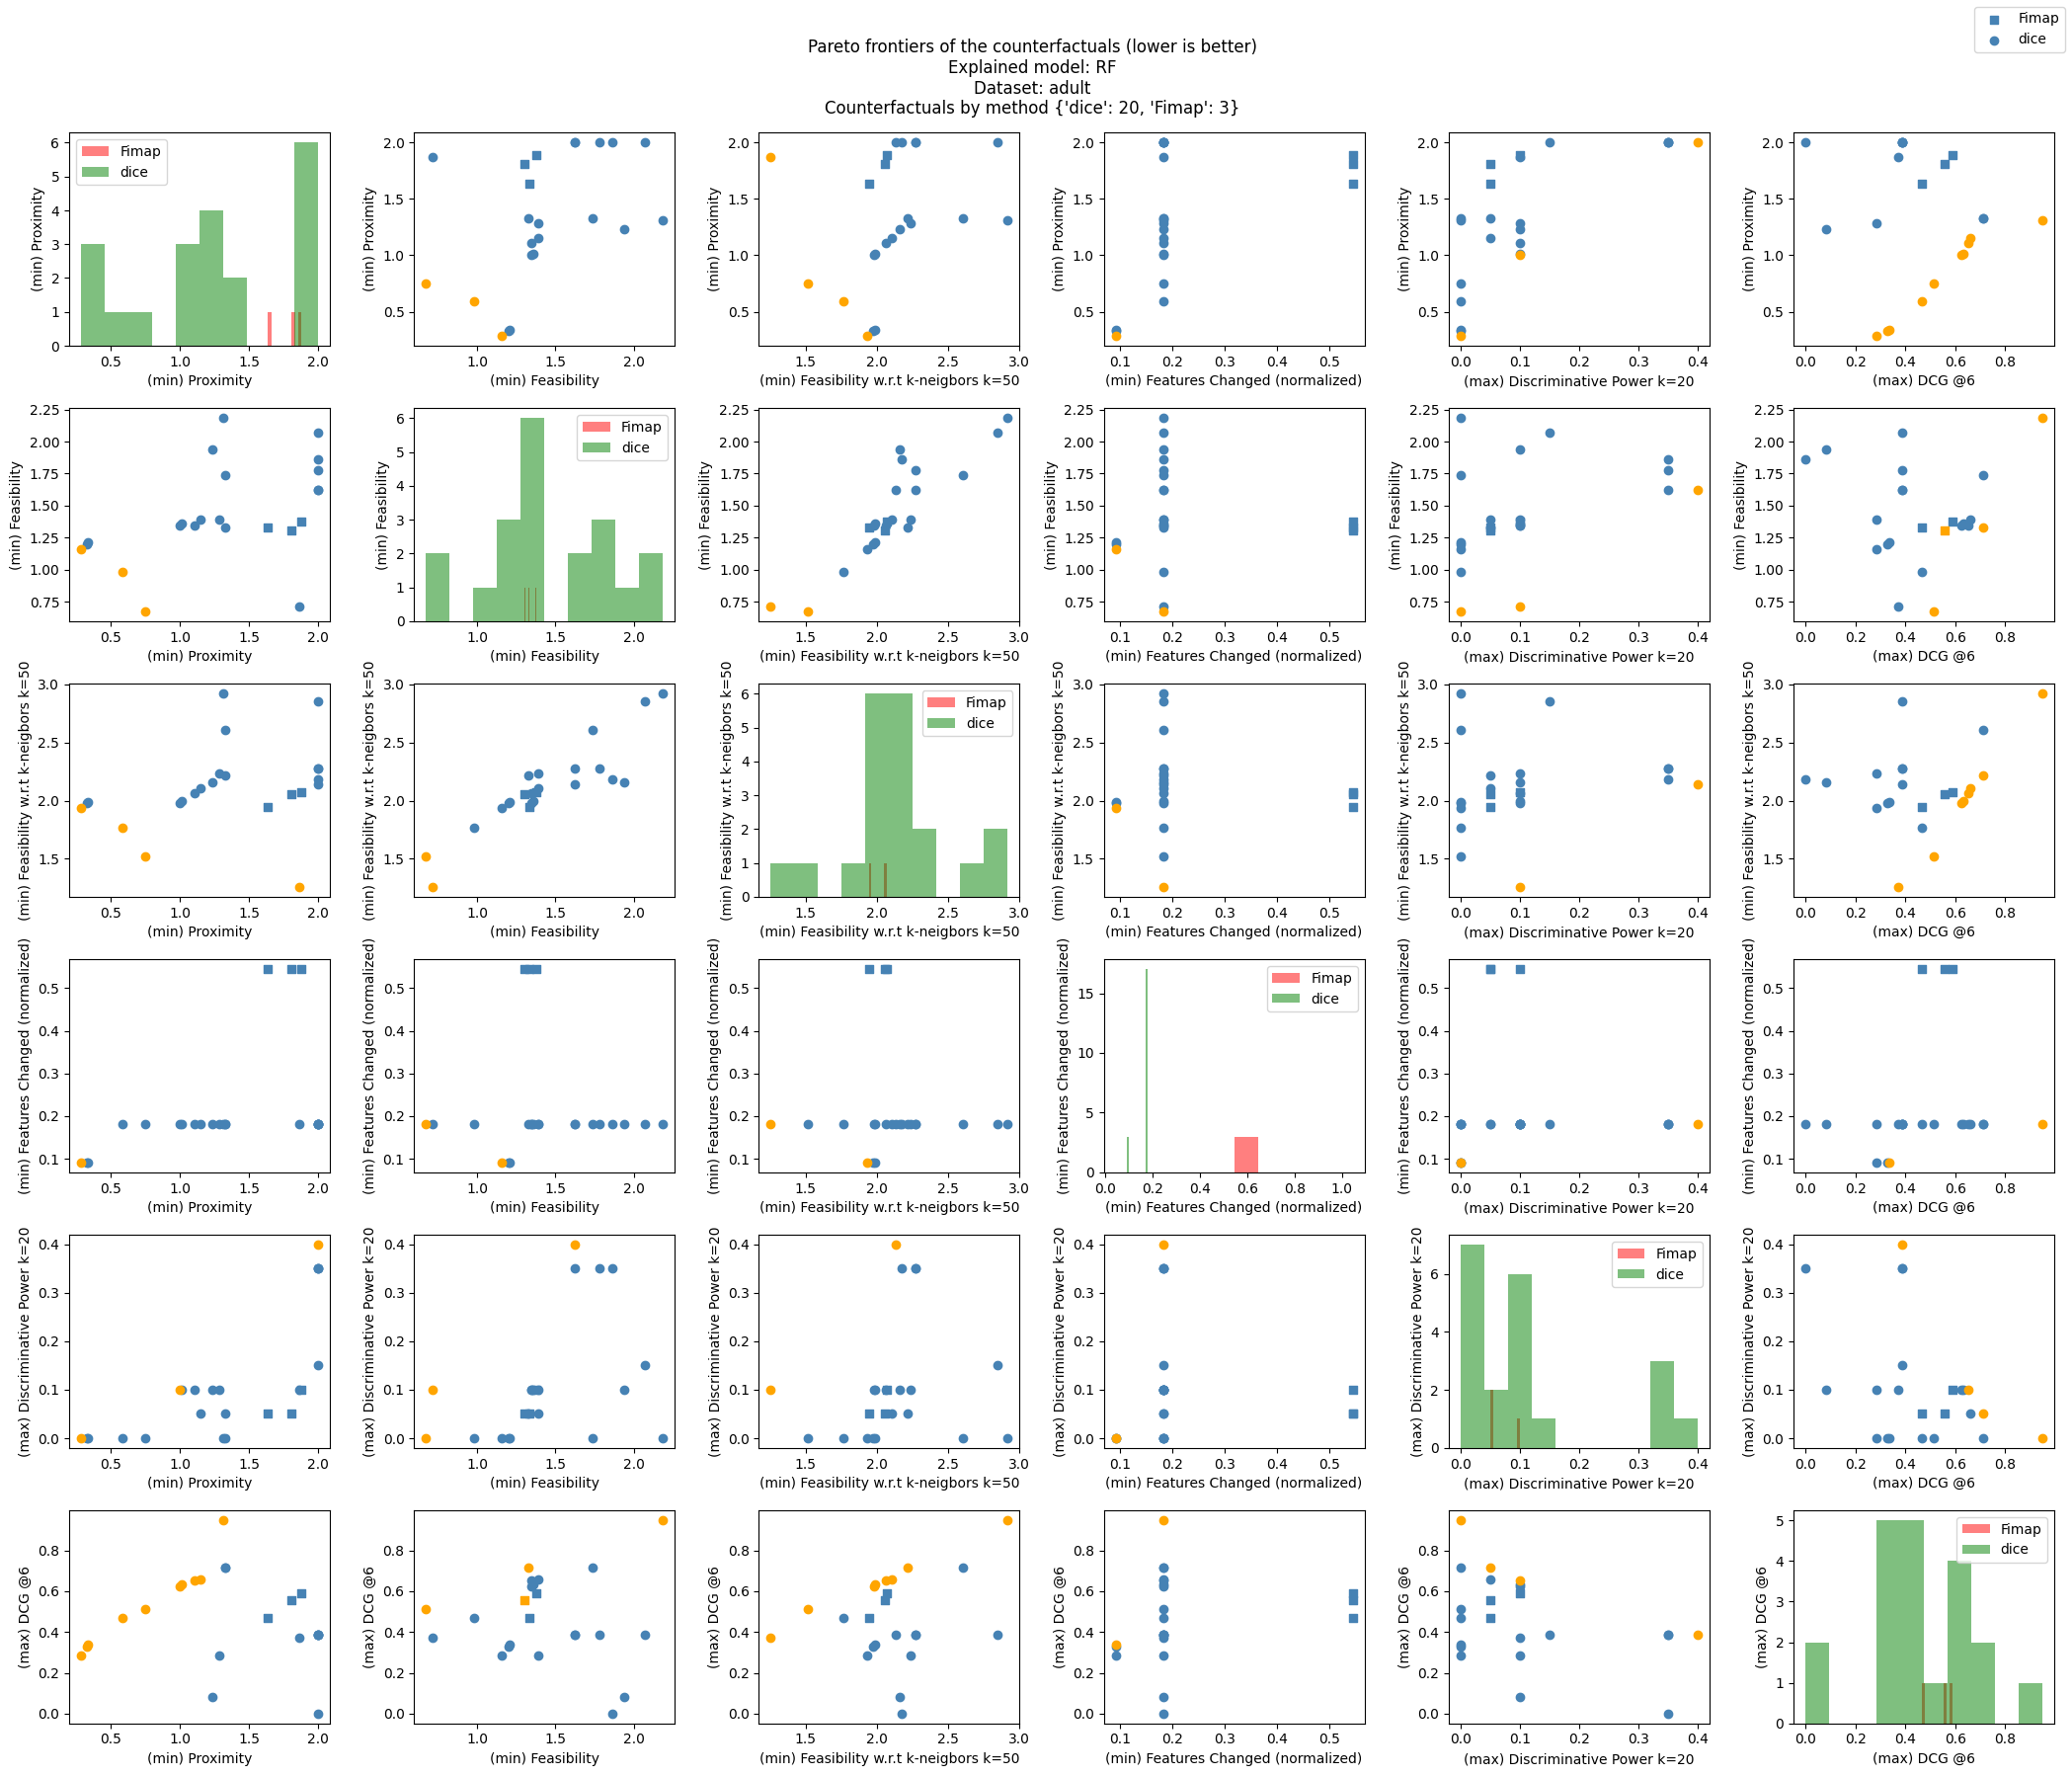

In [46]:
import matplotlib.pyplot as plt
from visualization_helpers import get_pareto_frontier_mask
from pareto import get_pareto_optimal_mask

#metrics_to_plot = ['proximity', 'features_changed', 'feasibility', 'dispreference_dcg', 'non_discriminative_power']
metrics_to_plot = scores_to_plot.drop(['explainer'], axis=1).columns.tolist()

n = len(metrics_to_plot)

fig, ax = plt.subplots(n, n, figsize=(3.5*n, 3*n))

colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w']
markers = ['s', 'o', 'v', '+', '*', 'p', 'P', 'X', 'D', '>']
labels = []

ax = ax.flatten()

for plot_round in ['nonpareto', 'pareto']:
    for i, other_metric in enumerate(metrics_to_plot):
        for j, metric in enumerate(metrics_to_plot):

            all_x = scores_to_plot[metric].to_numpy()
            all_y = scores_to_plot[other_metric].to_numpy()
            to_check = np.array([all_x, all_y], dtype=np.float64).T

            # Get pareto frontiers mask
            metric_direction = get_optimization_direction(metric)
            other_metric_direction = get_optimization_direction(other_metric)
            optimization_directions = [metric_direction, other_metric_direction]
            all_pareto = get_pareto_optimal_mask(data=to_check, optimization_direction=optimization_directions).astype('bool')



            ax[i*n+j].grid()

            for k, explainer in enumerate(scores_to_plot['explainer'].value_counts().sort_values(ascending=True).index.tolist()):

                mask = scores_to_plot['explainer'] == explainer
                pareto = all_pareto[mask]

                x = scores_to_plot[mask][metric].to_numpy()
                y = scores_to_plot[mask][other_metric].to_numpy()
            
                if plot_round == 'nonpareto':
                    if i == j:
                        ax[i*n+j].hist(x, color=colors[k], label=explainer, alpha=0.5)
                        ax[i*n+j].legend()
                    else:
                        ax[i*n+j].scatter(x[~pareto], y[~pareto], color='steelblue', marker=markers[k], label=explainer)
                elif plot_round == 'pareto' and i!=j:
                    ax[i*n+j].scatter(x[pareto], y[pareto], color='orange', marker=markers[k])

                    if i < j:
                        print(f'For explainer: {explainer} and metrics {metric}, {other_metric}, paretos: {sum(pareto)} out of {len(pareto)}')
                        # print(f'{scores_df[scores_df["explainer"] == explainer][[metric, other_metric]][pareto]}')
            
            ax[i*n+j].set_xlabel(f'({metric_direction}) {metric}')
            ax[i*n+j].set_ylabel(f'({other_metric_direction}) {other_metric}')
    # plt.title('Proximity vs Dispreference DCG \n(Pareto front in orange). \nLower is better.')

handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

counts = scores_df['explainer'].value_counts()

plt.suptitle(f'Pareto frontiers of the counterfactuals (lower is better)\nExplained model: {explained_model_name}\nDataset: {dataset_name}\nCounterfactuals by method {counts.to_dict()}\n')
plt.tight_layout()
plt.savefig(f'../images/{dataset_name}/{explained_model_name}/{dataset_name}_{explained_model_name}_pairplot_with_frontiers_{instance_to_explain_index}.png')
plt.show()

In [47]:
# scores_df[['feasibility', 'features_changed']]

In [48]:
# metric = 'feasibility'
# other_metric = 'features_changed'
# all_x = scores_df[metric].to_numpy()
# all_y = scores_df[other_metric].to_numpy()
# to_check = np.array([all_x, all_y], dtype=np.float64).T
# all_pareto = get_pareto_frontier_mask(to_check)
# scores_df[[metric, other_metric, 'explainer']][all_pareto]

In [49]:
# scores_df['explainer']